# 1. Import and Setup

In [258]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rnd
import re
import seaborn as sns

from scipy import stats
from scipy.stats import trim_mean
from scipy.stats import boxcox
from sklearn.covariance import MinCovDet
from statsmodels.robust.scale import mad

%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

cmap1 = "Blues"

In [259]:
# import data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df]

# 2. Exploratory Data Analysis

## 2.1. Data Structure

In [260]:
# df shape
for dataset in combine:
    dataset.shape

(891, 12)

(418, 11)

In [261]:
# sample rows
train_df.sample(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
332,333,0,1,"Graham, Mr. George Edward",male,38.0,0,1,PC 17582,153.4625,C91,S
190,191,1,2,"Pinsky, Mrs. (Rosa)",female,32.0,0,0,234604,13.0000,NaN,S
719,720,0,3,"Johnson, Mr. Malkolm Joackim",male,33.0,0,0,347062,7.7750,NaN,S
147,148,0,3,"Ford, Miss. Robina Maggie ""Ruby""",female,9.0,2,2,W./C. 6608,34.3750,NaN,S
794,795,0,3,"Dantcheff, Mr. Ristiu",male,25.0,0,0,349203,7.8958,NaN,S
614,615,0,3,"Brocklebank, Mr. William Alfred",male,35.0,0,0,364512,8.0500,NaN,S
742,743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C
363,364,0,3,"Asim, Mr. Adola",male,35.0,0,0,SOTON/O.Q. 3101310,7.0500,NaN,S


In [262]:
# columns, NULLs, and dtypes
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [263]:
train_df['Survived'].value_counts()/len(train_df)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

### Numerical Features
- Age, SibSp, ParCh, Fare

In [164]:
# describe numerical features
num_cols = ['Mean', 'TrMean', 'Median', 'StDev', 'MADev']
num_feats = ['Age', 'SibSp', 'Parch', 'Fare']
mean = []
trimmed_mean = []
median = []
stdev = []
madev = []

# calculate values
for feature in num_feats:
    mean.append(train_df[feature].dropna().mean())
    trimmed_mean.append(trim_mean(train_df[feature].dropna(), 0.1))
    median.append(train_df[feature].dropna().median())
    stdev.append(train_df[feature].dropna().std())
    madev.append(mad(train_df[feature].dropna()))

# create and view table
num_feats_df = pd.DataFrame(list(zip(mean, trimmed_mean, median, stdev, madev)),
                            index = num_feats,
                            columns = num_cols)
num_feats_df.T.round(3)

,Age,SibSp,Parch,Fare
Mean,29.699,0.523,0.382,32.204
TrMean,29.269,0.272,0.182,21.379
Median,28.000,0.000,0.000,14.454
StDev,14.526,1.103,0.806,49.693
MADev,13.343,0.000,0.000,10.236


Text(0.5, 1.0, 'Age Distribution')

Text(0, 0.5, '')

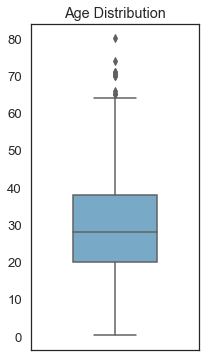

In [165]:
# AGE distribution - boxplot
sns.set(font_scale=1.2)
sns.set_style('white')
fig, ax = plt.subplots(figsize=(3, 6))
ax = sns.boxplot(train_df['Age'], width=0.5, orient='v', palette=cmap1)
ax.set_title('Age Distribution')
ax.set_ylabel('')

Text(0.5, 1.0, 'Sibling/Spouse Distribution')

Text(0.5, 0, '')

Text(0.5, 1.0, 'Parent/Children Distribution')

Text(0.5, 0, '')

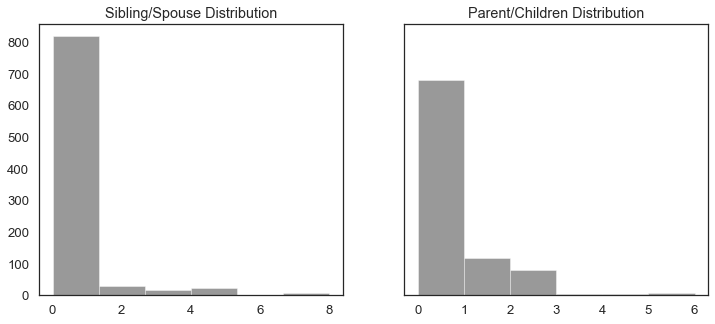

In [166]:
# SIBSP and PARCH distribution - histogram
sns.set(font_scale=1.2)
sns.set_style('white')
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12, 5))
sns.distplot(train_df['SibSp'], bins=6, kde=False, color='black', ax=ax1)
ax1.set_title('Sibling/Spouse Distribution')
ax1.set_xlabel('')
sns.distplot(train_df['Parch'], bins=6, kde=False, color='black', ax=ax2)
ax2.set_title('Parent/Children Distribution')
ax2.set_xlabel('')

# NOTE: Mostly zeroes

Text(0.5, 1.0, 'Fare Distribution')

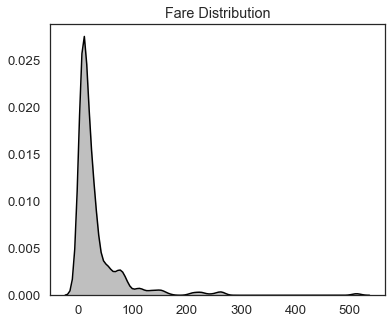

In [167]:
# FARE distribution - kernel density estimate
sns.set(font_scale=1.2)
sns.set_style('white')
fig, ax = plt.subplots(figsize=(6, 5))
sns.kdeplot(train_df['Fare'], shade=True, color='black', label='', bw=8)
ax.set_title('Fare Distribution')

# NOTE: right-skewed, needs to be transformed

### Categorical Features
- Pclass, Sex, Embarked

In [168]:
# describe categorical features
cat_feats = ['Pclass', 'Sex', 'Embarked']
for feature in cat_feats:
    train_df[feature].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

male      577
female    314
Name: Sex, dtype: int64

S    644
C    168
Q     77
Name: Embarked, dtype: int64

([<matplotlib.patches.Wedge at 0x288f7ce8648>,
 [Text(-0.8280948334907877, 0.8684808269304882, ''),
  Text(-0.9896099621739102, -0.6787283129250999, ''),
  Text(1.1845905819442033, -0.19169025319273209, '')],
 [Text(-0.48305531953629277, 0.5066138157094515, '24%'),
  Text(-0.5772724779347809, -0.3959248492063082, '21%'),
  Text(0.6910111728007853, -0.11181931436242705, '55%')])

Text(0.5, 1.0, 'Class Distribution')

([<matplotlib.patches.Wedge at 0x288f96242c8>,
 [Text(-0.913931440427621, -0.7776434415578223, ''),
  Text(1.0893052658702065, 0.5034024610065377, ''),
  Text(0.3225130788540454, 1.155848309237888, '')],
 [Text(-0.5331266735827789, -0.45362534090872964, '72%'),
  Text(0.6354280717576204, 0.293651435587147, '19%'),
  Text(0.18813262933152647, 0.6742448470554346, '9%')])

Text(0.5, 1.0, 'Embarkment Distribution')

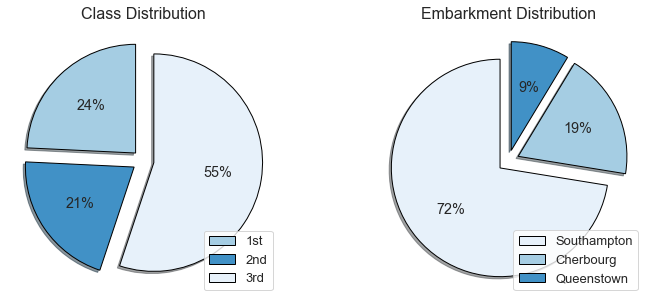

In [169]:
# PCLASS distribution - pie chart
labels_1 = '1st', '2nd', '3rd'
labels_2 = 'Southampton', 'Cherbourg', 'Queenstown'
cmap = plt.get_cmap("Blues")
colors_1 = cmap([90, 160, 20])
colors_2 = cmap([20, 90, 160])

fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
ax[0].pie([216, 184, 491], startangle=90, colors=colors_1, wedgeprops={'edgecolor':'black'}, 
        autopct='%1.f%%', shadow=True, explode=(0.1, 0.1, 0.1))
ax[0].set_title('Class Distribution', fontsize=16)
ax[0].legend(labels=labels_1, fontsize=13, loc=4)
ax[1].pie([644, 168, 77], startangle=90, colors=colors_2, wedgeprops={'edgecolor':'black'},
        autopct='%1.f%%', shadow=True, explode=(0.1, 0.1, 0.1))
ax[1].set_title('Embarkment Distribution', fontsize=16)
ax[1].legend(labels=labels_2, fontsize=13, loc=4)

## 2.2. Clean Dataset

- Address NULLs
- Split 'Cabin' into Deck, Rm_Num
- Split 'Name' into Title, Last
- Address Party Info

### Address NULLs

In [170]:
# create tables of % NULLs
for dataset in combine:
    pd.DataFrame({'Percent_NULL': (dataset.isnull().sum()/len(dataset)*100).sort_values(ascending=False)}).head(4)

,Percent_NULL
Cabin,77.104377
Age,19.865320
Embarked,0.224467
Fare,0.000000


,Percent_NULL
Cabin,78.229665
Age,20.574163
Fare,0.239234
Embarked,0.000000


The majority of cabin assignments are unknown but, if possible, I'd like to salvage this feature. It seems likely to influence survival. For now, I will assign a placeholder ('Z') for NULL values.

In [171]:
# fill NULLs with 'Z'
for dataset in combine:
    dataset['Cabin'].fillna('Z', inplace=True)

Other features could give us clues about passenger age. I will assign a placeholder (0) for NULL values until I can address it properly.

In [172]:
# fill NULLs with 0
for dataset in combine:
    dataset['Age'].fillna(0, inplace=True)

Embarkment location and fare are almost complete, so I will fill NULL values with the mode and mean, respectively.

In [173]:
# fill NULLs with mode/mean
for dataset in combine:
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)
    dataset['Fare'].fillna(dataset['Fare'].mean(), inplace=True)

In [174]:
# QA check
for dataset in combine:
    pd.DataFrame({'Percent_NULL': (dataset.isnull().sum()/len(dataset)*100).sort_values(ascending=False)}).head(4)

,Percent_NULL
Embarked,0.0
Cabin,0.0
Fare,0.0
Ticket,0.0


,Percent_NULL
Embarked,0.0
Cabin,0.0
Fare,0.0
Ticket,0.0


### Split Cabin Info

Cabin data (ex. A35) contain three different pieces of information: deck (A), cabin number (35), and cabin count (35, 40, 41 = 3 cabins). As such, I want to split 'Cabin' into 'Deck', 'CabinNum', and 'CabinCnt'.

In [175]:
# split 'Cabin' into 'CabinNum', 'Deck', and 'CabinCnt'
for dataset in combine:
    dataset['Deck'] = dataset['Cabin'].apply(lambda x: re.findall(r"\D", x)[0])
    dataset['CabinNum'] = dataset['Cabin'].apply(lambda x: re.findall(r"\d{1,500}", x))
    dataset['CabinCnt'] = dataset['CabinNum'].apply(lambda x: len(x) if len(x)>0 else 0)
    dataset['CabinNum'] = dataset['CabinNum'].apply(lambda x: x[0] if len(x)>0 else 0)

### Split Name Info

I want to parse 'Name' and keep the pieces I think are informative.

In [176]:
# split 'Name' into 'Last' and 'Title'
for dataset in combine:
    dataset['Last'] = dataset['Name'].apply(lambda x: x.split(',', 2)[0])
    dataset['Name'] = dataset['Name'].apply(lambda x: x.split(',', 2)[1])
    dataset['Title'] = dataset['Name'].apply(lambda x: x.split('.', 2)[0])

In [177]:
# clean up 'Title'
for dataset in combine:
    dataset['Title'].nunique()
    titles = dataset['Title'].value_counts().reset_index(name='count').query('count>10')['index'].tolist()
    dataset['Title'] = dataset['Title'].apply(lambda x: x if x in titles else 'Other')
    print('Titles with >10 Records: {}'.format(titles))

17

Titles with >10 Records: [' Mr', ' Miss', ' Mrs', ' Master']


9

Titles with >10 Records: [' Mr', ' Miss', ' Mrs', ' Master']


### Party Info
Tickets, ParCh, and SibSp might contain information about how many other passengers a passenger knew. This could impact survival and fare. I want to create 'GroupSize', 'FamilySize' and 'IsAlone' to hold this information.

In [178]:
# calculate 'GroupSize' for shared tickets
for dataset in combine:
    ticket_ref = dataset['Ticket'].value_counts().reset_index(name='count')
    dataset['GroupSize'] = dataset['Ticket'].apply(lambda x: ticket_ref.loc[ticket_ref['index']==x, 'count'].tolist()[0])

In [179]:
# calculate 'FamilySize'
for dataset in combine:
    dataset['FamilySize'] = dataset['Parch'] + dataset['SibSp']+1

In [180]:
# Create 'IsAlone' based on 'GroupSize' and 'FamilySize'
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[(dataset['GroupSize'] == 1) & (dataset['FamilySize'] == 1), 'IsAlone'] = 1

### Streamline Dataset

In [181]:
# check RAW dataset
for dataset in combine:
    dataset.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,CabinNum,CabinCnt,Last,Title,GroupSize,FamilySize,IsAlone
673,674,1,2,Mr. Charles,male,31.0,0,0,244270,13.0000,Z,S,Z,0,0,Wilhelms,Mr,1,1,1
43,44,1,2,Miss. Simonne Marie Anne Andree,female,3.0,1,2,SC/Paris 2123,41.5792,Z,C,Z,0,0,Laroche,Miss,3,4,0
285,286,0,3,Mr. Ivan,male,33.0,0,0,349239,8.6625,Z,C,Z,0,0,Stankovic,Mr,1,1,1


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,CabinNum,CabinCnt,Last,Title,GroupSize,FamilySize,IsAlone
59,951,1,Miss. Victorine,female,36.0,0,0,PC 17608,262.3750,B61,C,B,61,1,Chaudanson,Miss,5,1,0
147,1039,3,Mr. Evan,male,22.0,0,0,SC/A4 23568,8.0500,Z,S,Z,0,0,Davies,Mr,1,1,1
269,1161,3,Mr. Mate,male,17.0,0,0,315095,8.6625,Z,S,Z,0,0,Pokrnic,Mr,1,1,1


In [182]:
# drop uninformative columns
for dataset in combine:
    dataset.drop(columns=['Name', 'SibSp', 'Parch', 'Ticket', 
                          'Cabin', 'CabinCnt', 'Last'], inplace=True)

In [183]:
# rename columns
for dataset in combine:
    dataset.rename(columns={'PassengerId':'ID', 'Pclass':'Class', 'CabinNum':'Cabin'}, inplace=True)

In [184]:
# re-order columns
train_cols = ['ID', 'Title', 'Sex', 'Age', 'FamilySize', 'GroupSize', 'IsAlone', 'Class', 'Fare', 'Deck', 'Cabin', 'Embarked', 'Survived']
test_cols = ['ID', 'Title', 'Sex', 'Age', 'FamilySize', 'GroupSize', 'IsAlone', 'Class', 'Fare', 'Deck', 'Cabin', 'Embarked']
train_df = train_df[train_cols]
test_df = test_df[test_cols]
combine = [train_df, test_df]

In [185]:
# make columns numeric
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})
    dataset['Deck'] = dataset['Deck'].map({'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8, 'Z':8})
    dataset['Embarked'] = dataset['Embarked'].map({'C':1, 'Q':2, 'S':3})
    dataset['Title'] = dataset['Title'].map({' Mr':1, ' Mrs':2, ' Master':3, ' Miss':4, 'Other':5})

In [186]:
# change dtypes
for dataset in combine:
    dataset['Cabin'] = dataset['Cabin'].astype('int64')
    dataset['Age'] = round(dataset['Age'], 0).astype('int64')

In [187]:
# round floats
for dataset in combine:
    dataset['Fare'] = round(dataset['Fare'], 2)

In [188]:
# QA check
for dataset in combine:
    dataset.sample(3)
    dataset.info()
    dataset.describe()

,ID,Title,Sex,Age,FamilySize,GroupSize,IsAlone,Class,Fare,Deck,Cabin,Embarked,Survived
386,387,3,0,1,8,6,0,3,46.90,8,0,3,0
760,761,1,0,0,1,2,0,3,14.50,8,0,3,0
118,119,1,0,24,2,2,0,1,247.52,2,58,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          891 non-null    int64  
 1   Title       891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    int64  
 4   FamilySize  891 non-null    int64  
 5   GroupSize   891 non-null    int64  
 6   IsAlone     891 non-null    int64  
 7   Class       891 non-null    int64  
 8   Fare        891 non-null    float64
 9   Deck        891 non-null    int64  
 10  Cabin       891 non-null    int64  
 11  Embarked    891 non-null    int64  
 12  Survived    891 non-null    int64  
dtypes: float64(1), int64(12)
memory usage: 90.6 KB


,ID,Title,Sex,Age,FamilySize,GroupSize,IsAlone,Class,Fare,Deck,Cabin,Embarked,Survived
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,1.964085,0.352413,23.794613,1.904602,1.787879,0.518519,2.308642,32.204366,6.945006,11.333333,2.536476,0.383838
std,257.353842,1.309795,0.477990,17.593200,1.613459,1.361142,0.499938,0.836071,49.693414,2.061500,26.914597,0.791503,0.486592
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,223.500000,1.000000,0.000000,6.000000,1.000000,1.000000,0.000000,2.000000,7.910000,8.000000,0.000000,2.000000,0.000000
50%,446.000000,1.000000,0.000000,24.000000,1.000000,1.000000,1.000000,3.000000,14.450000,8.000000,0.000000,3.000000,0.000000
75%,668.500000,3.000000,1.000000,35.000000,2.000000,2.000000,1.000000,3.000000,31.000000,8.000000,0.000000,3.000000,1.000000
max,891.000000,5.000000,1.000000,80.000000,11.000000,7.000000,1.000000,3.000000,512.330000,8.000000,148.000000,3.000000,1.000000


,ID,Title,Sex,Age,FamilySize,GroupSize,IsAlone,Class,Fare,Deck,Cabin,Embarked
50,942,1,0,24,2,2,0,1,60.00,3,31,3
115,1007,1,0,18,2,1,0,3,14.45,8,0,1
126,1018,1,0,22,1,1,1,3,7.80,8,0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          418 non-null    int64  
 1   Title       418 non-null    int64  
 2   Sex         418 non-null    int64  
 3   Age         418 non-null    int64  
 4   FamilySize  418 non-null    int64  
 5   GroupSize   418 non-null    int64  
 6   IsAlone     418 non-null    int64  
 7   Class       418 non-null    int64  
 8   Fare        418 non-null    float64
 9   Deck        418 non-null    int64  
 10  Cabin       418 non-null    int64  
 11  Embarked    418 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 39.3 KB


,ID,Title,Sex,Age,FamilySize,GroupSize,IsAlone,Class,Fare,Deck,Cabin,Embarked
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,1100.500000,1.899522,0.363636,24.028708,1.839713,1.349282,0.555024,2.265550,35.627344,6.976077,10.145933,2.401914
std,120.810458,1.230878,0.481622,17.593168,1.519072,0.757069,0.497559,0.841838,55.840762,2.048431,24.117523,0.854496
min,892.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
25%,996.250000,1.000000,0.000000,9.000000,1.000000,1.000000,0.000000,1.000000,7.900000,8.000000,0.000000,2.000000
50%,1100.500000,1.000000,0.000000,24.000000,1.000000,1.000000,1.000000,3.000000,14.450000,8.000000,0.000000,3.000000
75%,1204.750000,3.000000,1.000000,35.750000,2.000000,1.000000,1.000000,3.000000,31.500000,8.000000,0.000000,3.000000
max,1309.000000,5.000000,1.000000,76.000000,11.000000,5.000000,1.000000,3.000000,512.330000,8.000000,132.000000,3.000000


### Re-visiting NULLS
I still need to deal with incompleteness in 'Age', 'Deck', and 'Cabin'.  However, without a strong understand of how these features are correlated with other features, my generated values will be purely random and hurt model performance. I will return to this after 2.3.

## 2.3. Explore Bivariate Relationships
### Correlation Matrix

Text(0.5, 1.0, 'Correlation Heatmap')

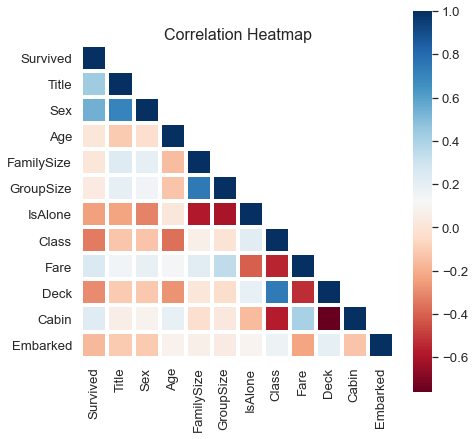

In [189]:
# correlation heatmap
params = ['Survived', 'Title', 'Sex', 'Age', 'FamilySize', 'GroupSize', 'IsAlone', 'Class', 'Fare', 'Deck', 'Cabin', 'Embarked']
coefs = np.corrcoef(train_df[params].values.T)
mask = np.zeros_like(coefs)
mask[np.triu_indices_from(mask, 1)] = True
with sns.axes_style('white'):
    f, ax = plt.subplots(figsize=(7, 7))
    sns.set(font_scale=1.2)
    sns.heatmap(coefs, cmap='RdBu', cbar=True, annot=False, square=True, fmt='.1f', annot_kws={'size':12},
               yticklabels=params, xticklabels=params, linewidths=3, linecolor='white', mask=mask)
    ax.set_title('Correlation Heatmap', fontsize=16)

Correlated Features
- Survived x Sex
- PartySize x IsAlone
- Class x Cabin, Deck, Fare
- Fare x Deck
- Deck x Cabin

'Deck' and 'Cabin' are correlated because they are equally incomplete. How do they relate to the target variable, 'Survived'? 

In [190]:
# create subset where 'Cabin' is known
cabin_df = train_df[train_df['Deck'] != 8]

Text(0.5, 1.0, 'Survival by Cabin Assignment')

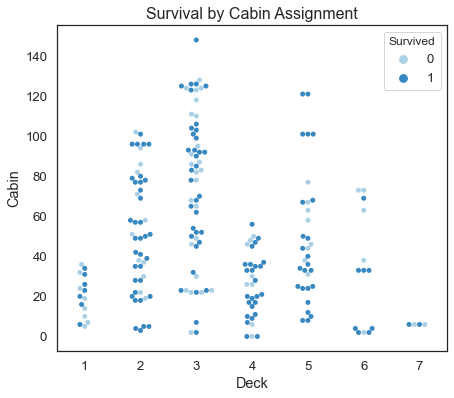

In [191]:
# create swarmplot
fig, ax = plt.subplots(figsize=(7, 6))
sns.swarmplot(x='Deck', y='Cabin', hue='Survived', palette=cmap1, data=cabin_df)
ax.set_title('Survival by Cabin Assignment', fontsize=16)

Even amongst passengers where cabin assignment is known, there is no clear relationship with 'Survived'. Given that cabin assignment is unknown for ~80% of passengers, this feature should be excluded from modeling.

In [192]:
# drop 'Deck' and 'Cabin'
for dataset in combine:
    dataset.drop(columns=['Deck', 'Cabin'], inplace=True)

'PartySize' and 'GroupSize' are correlated with 'IsAlone' because they were used to create it. How do they each relate to the target variable, 'Survived'?

Text(0.5, 1.0, 'Survival by IsAlone')

Text(0.5, 1.0, 'Survival by Family Size')

Text(0.5, 1.0, 'Survival by Group Size')

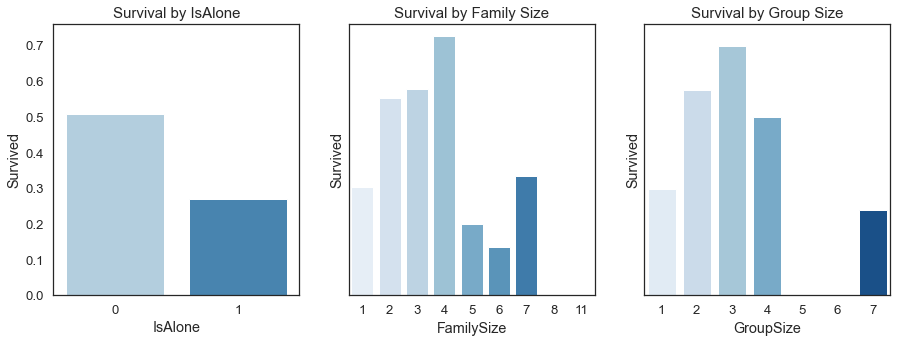

In [193]:
sns.set(font_scale=1.2)
sns.set_style('white')
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(15, 5))
sns.barplot(x='IsAlone', y='Survived', data=train_df, ci=None, palette=cmap1, ax=ax1)
ax1.set_title('Survival by IsAlone', fontsize=15)
sns.barplot(x='FamilySize', y='Survived', data=train_df, ci=None, palette=cmap1, ax=ax2)
ax2.set_title('Survival by Family Size', fontsize=15)
sns.barplot(x='GroupSize', y='Survived', data=train_df, ci=None, palette=cmap1, ax=ax3)
ax3.set_title('Survival by Group Size', fontsize=15)

Being alone or in a large party decreased your chance of surviving. A more meaningful designation may be a single feature, 'Connections', binned as "None" (1), "Some" (2-4), and "Many" (>4).

In [194]:
# create 'Connections'
for dataset in combine:
    dataset['Connections'] = 0
    dataset.loc[dataset['IsAlone'] == 1, 'Connections'] = 1 # alone
    dataset.loc[dataset['IsAlone'] == 0, 'Connections'] = 2 # some connections
    dataset.loc[(dataset['FamilySize'] > 4) | (dataset['GroupSize'] > 4), 'Connections'] = 3 # many connections

Text(0.5, 1.0, 'Survival by Connections (binned)')

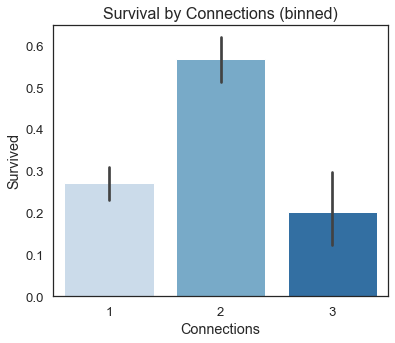

In [195]:
sns.set(font_scale=1.2)
sns.set_style('white')
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.barplot(x='Connections', y='Survived', data=train_df, palette=cmap1)
ax.set_title('Survival by Connections (binned)', fontsize=16)

'Connections' appears to be a strong substitute so I can drop 'FamilySize' and 'IsAlone' from analysis. I will keep 'GroupSize' to adjust 'Fare' later.

In [196]:
# drop 'FamilySize' and 'IsAlone'
for dataset in combine:
    dataset.drop(columns=['FamilySize', 'IsAlone'], inplace=True)

### Meaningful Correlations
- Survived x Sex
- Class x Fare

NOTE: Correlations only pick up on linear relationships.

Text(0.5, 1.0, 'Survival Rate by Sex')

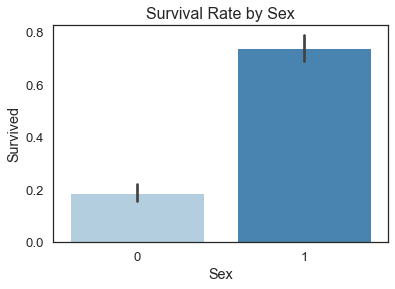

In [197]:
# SURVIVED x SEX
ax = sns.barplot(x='Sex', y='Survived', data=train_df, palette=cmap1)
ax.set_title('Survival Rate by Sex', fontsize=16)

Text(0.5, 1.0, 'Fare by Economic Class')

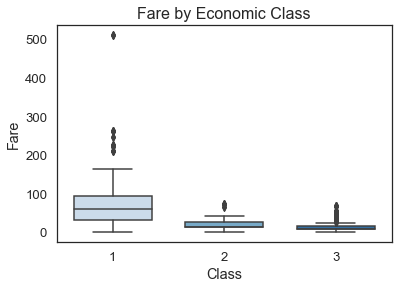

In [198]:
# CLASS x FARE
ax = sns.boxplot(x='Class', y='Fare', data=train_df, width=0.7, palette=cmap1)
ax.set_title('Fare by Economic Class', fontsize=16)

I remembered from earlier that 'Fare' is extremely right-skewed. I also remembered that 'Fare' may be impacted by shared tickets. I want to fix both of these issues and try plotting this relationship again.

In [199]:
# account for shared tickets
for dataset in combine:
    dataset['Adj_Fare'] = dataset['Fare']/dataset['GroupSize']

In [200]:
# transform 'Fare' and 'Adj_Fare'
for dataset in combine:
    dataset['Adj_Fare(log)'] = np.log1p(dataset['Adj_Fare'])
    dataset['Fare(log)'] = np.log1p(dataset['Fare'])

Text(0.5, 1.0, 'Fare by Economic Class')

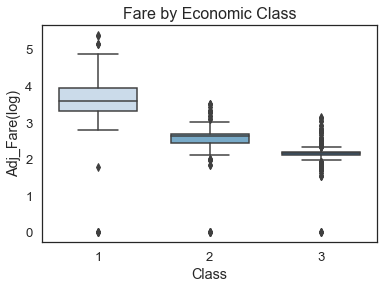

In [201]:
# CLASS x ADJ_FARE(log)
ax = sns.boxplot(x='Class', y='Adj_Fare(log)', data=train_df, width=0.7, palette=cmap1)
ax.set_title('Fare by Economic Class', fontsize=16)

'Fare' was more uniform for 2nd and 3rd class passengers than for 1st class passengers. I noticed that quite a few passengers had a 'Fare' of $0.00.

In [202]:
# investigate 'Fare'
train_df[train_df['Fare'] == 0]

,ID,Title,Sex,Age,GroupSize,Class,Fare,Embarked,Survived,Connections,Adj_Fare,Adj_Fare(log),Fare(log)
179,180,1,0,36,4,3,0.0,3,0,2,0.0,0.0,0.0
263,264,1,0,40,1,1,0.0,3,0,1,0.0,0.0,0.0
271,272,1,0,25,4,3,0.0,3,1,2,0.0,0.0,0.0
277,278,1,0,0,3,2,0.0,3,0,2,0.0,0.0,0.0
302,303,1,0,19,4,3,0.0,3,0,2,0.0,0.0,0.0
413,414,1,0,0,3,2,0.0,3,0,2,0.0,0.0,0.0
466,467,1,0,0,3,2,0.0,3,0,2,0.0,0.0,0.0
481,482,1,0,0,1,2,0.0,3,0,1,0.0,0.0,0.0
597,598,1,0,49,4,3,0.0,3,0,2,0.0,0.0,0.0
633,634,1,0,0,1,1,0.0,3,0,1,0.0,0.0,0.0


I think these are crew members. They are all male, all but one died, and all of them embarked at the same place. I want to add "Crew" as a 4th passenger class and should consider dropping 'Fare'.

In [203]:
# add "Crew" (4) to 'Class'
for dataset in combine:
    dataset.loc[dataset['Fare'] == 0, 'Class'] = 4
    dataset['Class'].value_counts()

3    487
1    211
2    178
4     15
Name: Class, dtype: int64

3    218
1    105
2     93
4      2
Name: Class, dtype: int64

Text(0.5, 1.0, 'Survival Rate by Economic Class')

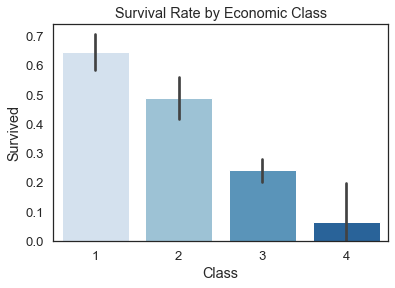

In [204]:
# SURVIVED x CLASS
ax = sns.barplot(x='Class', y='Survived', data=train_df, palette=cmap1)
ax.set_title('Survival Rate by Economic Class')

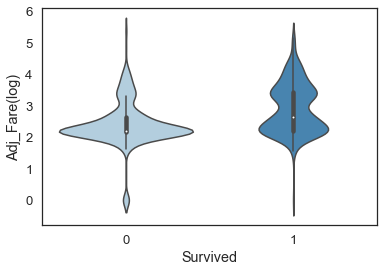

In [205]:
# SURVIVED x FARE
ax = sns.violinplot(x='Survived', y='Adj_Fare(log)', data=train_df, palette=cmap1)

### Hypothesized Relationships

Correlations may not pick up all meaningful relationships. I hypothesized a few additional relationships to test.
- Survived x Class
- Survived x Title
- Survived x Age

Text(0.5, 1.0, 'Survival Rate by Passenger Class')

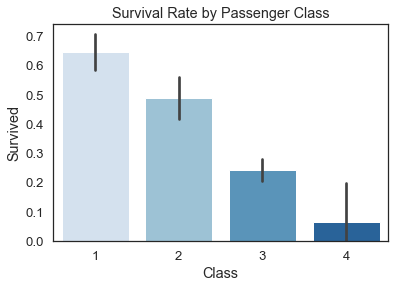

In [206]:
# SURVIVED x CLASS
ax = sns.barplot(x='Class', y='Survived', data=train_df, palette=cmap1)
ax.set_title('Survival Rate by Passenger Class')

Text(0.5, 1.0, 'Survival Rate by Title')

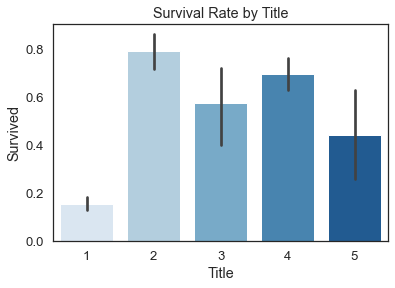

In [207]:
# SURVIVED x TITLE
ax = sns.barplot(x='Title', y='Survived', data=train_df, palette=cmap1)
ax.set_title('Survival Rate by Title')

Before I plot SURVIVED x AGE, I want use features influencing 'Age' to complete the NULL values I filled with a placeholder (0) earlier on.
- Sex
- Title
- Class

In [208]:
# empty 3d matrix
complete_age = np.zeros((2, 5, 4))

# subset with REAL ages
age_df = train_df[train_df['Age'] != 0]

# complete 'Age' with group medians
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 5):
            for k in range(0, 4):
                age_record = age_df[(age_df['Sex'] == i) & \
                                    (age_df['Title'] == j + 1) & \
                                    (age_df['Class'] == k + 1)]['Age']
                grp_median = age_record.median()
                if np.isnan(grp_median):
                    grp_median = 0
                complete_age[i, j, k] = int(grp_median)
    for i in range(0, 2):
        for j in range(0, 5):
            for k in range(0, 4):
                dataset.loc[(dataset['Age'] == 0) & \
                            (dataset['Sex'] == i) & \
                            (dataset['Title'] == j + 1) & \
                            (dataset['Class'] == k + 1), 'Age'] = complete_age[i, j, k]
    dataset['Age'] = dataset['Age'].astype(int)

0

1

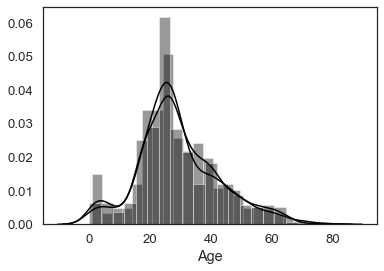

In [209]:
# QA check
for dataset in combine:
    len(dataset.loc[dataset['Age'] == 0])
    sns.distplot(dataset['Age'], color='black')

Text(0.5, 1.0, 'Age Distribution by Survived')

[Text(0, 0, 'No'), Text(0, 0, 'Yes')]

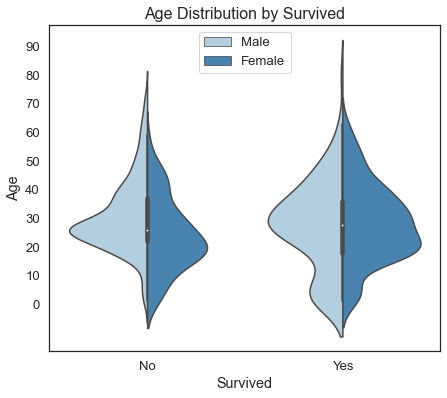

In [210]:
# SURVIVED x AGE
sns.set(font_scale=1.2)
sns.set_style('white')
fig, ax = plt.subplots(figsize=(7, 6))
sns.violinplot(x='Survived', y='Age', hue='Sex', data=train_df, split=True, palette=cmap1, legend_out=True)
ax.set_title('Age Distribution by Survived', fontsize=16)
ax.set_yticks(np.arange(0, 100, 10))
ax.set_xticklabels(labels=['No', 'Yes'])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Male', 'Female'], loc="upper center")

## 2.4. Explore Multivariate Relationships
I had a good understanding of the dataset at this point and could have moved onto modeling, but I had a few un-answered questions.
- Was class-specific survival uniform across 'Age' and 'Sex'?
- How was 'Fare' calculated for groups sharing a ticket?
- Was 'Embarkment' random?

Text(0.5, 1.0, 'Influence of Title and Class on Survival Rate')

Text(0, 0.5, 'Survival Rate')

[Text(0, 0, 'Mr'),
 Text(0, 0, 'Mrs'),
 Text(0, 0, 'Master'),
 Text(0, 0, 'Miss'),
 Text(0, 0, 'Other')]

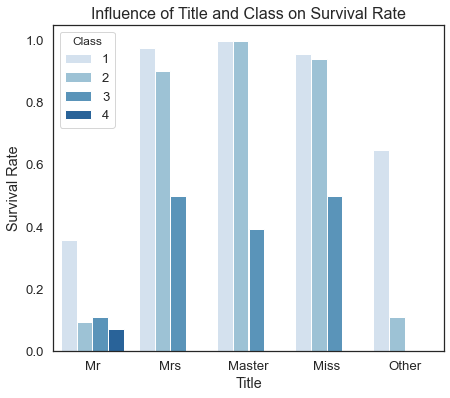

In [211]:
# class-specific survival
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.barplot(x='Title', y='Survived', hue='Class', data=train_df, ci=None, palette=cmap1)
ax.set_title('Influence of Title and Class on Survival Rate', fontsize=16)
ax.set_ylabel('Survival Rate')
ax.set_xticklabels(labels=['Mr', 'Mrs', 'Master', 'Miss', 'Other'])

Text(0.5, 1.0, 'Fare by Connections across Class')

Text(0, 0.5, 'Fare')

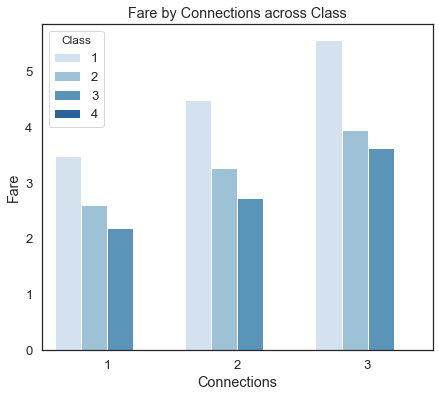

In [212]:
# un-adjusted fare
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.barplot(x='Connections', y='Fare(log)', hue='Class', data=train_df, ci=None, palette=cmap1)
ax.set_title('Fare by Connections across Class')
ax.set_ylabel('Fare')

It appears to cost more to travel in a group, suggesting that individuals who shared a ticket paid a lump sum. I accounted for this with 'Adj_Fare'.

Text(0.5, 1.0, 'Fare by Connections and Survived')

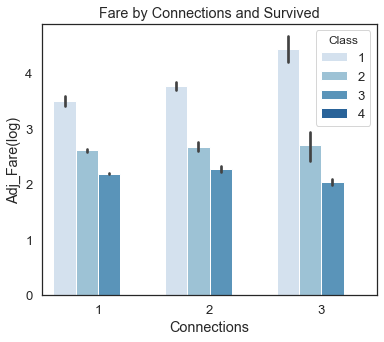

In [213]:
# adjusted fare
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.barplot(x='Connections', y='Adj_Fare(log)', hue='Class', data=train_df, palette=cmap1)
ax.set_title('Fare by Connections and Survived')

In [214]:
# embarkment pivot table
embark_df = pd.pivot_table(train_df, values=['Survived', 'ID'], index=['Embarked', 'Class'], 
                           aggfunc={'Survived': np.mean, 'ID': pd.Series.nunique}, margins=True, margins_name='Total')
embark_df.reset_index(inplace=True)
embark_df.rename(columns={'Embarked':'Location', 'ID':'Count', 
                          'Survived':'% Survived'})

,Location,Class,Count,% Survived
0,1,1,85,0.694118
1,1,2,17,0.529412
2,1,3,66,0.378788
3,2,1,2,0.500000
4,2,2,3,0.666667
5,2,3,72,0.375000
6,3,1,124,0.612903
7,3,2,158,0.481013
8,3,3,349,0.189112
9,3,4,15,0.066667


In [215]:
train_df.head()

,ID,Title,Sex,Age,GroupSize,Class,Fare,Embarked,Survived,Connections,Adj_Fare,Adj_Fare(log),Fare(log)
0,1,1,0,22,1,3,7.25,3,0,2,7.25,2.110213,2.110213
1,2,2,1,38,1,1,71.28,1,1,2,71.28,4.280547,4.280547
2,3,4,1,26,1,3,7.92,3,1,1,7.92,2.188296,2.188296
3,4,2,1,35,2,1,53.10,3,1,2,26.55,3.316003,3.990834
4,5,1,0,35,1,3,8.05,3,0,1,8.05,2.202765,2.202765


## 2.5. Final Streamline

In [216]:
# drop columns
for dataset in combine:
    dataset.drop(columns=['GroupSize', 'Fare', 'Adj_Fare', 'Fare(log)'], inplace=True)

In [217]:
# rename columns
for dataset in combine:
    dataset.rename(columns={'Adj_Fare(log)':'Fare'}, inplace=True)

In [218]:
# round floats
for dataset in combine:
    dataset['Fare'] = round(dataset['Fare'], 2)

In [219]:
# final QA check
for dataset in combine:
    dataset.sample(8)
    dataset.info()
    dataset.describe()

,ID,Title,Sex,Age,Class,Embarked,Survived,Connections,Fare
823,824,2,1,27,3,3,1,2,1.98
431,432,2,1,31,3,3,1,2,2.20
720,721,4,1,6,2,3,1,2,2.48
724,725,1,0,27,1,3,1,2,3.32
96,97,1,0,71,1,1,0,1,3.57
666,667,1,0,25,2,3,0,1,2.64
112,113,1,0,22,3,3,0,1,2.20
867,868,1,0,31,1,3,0,1,3.94


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           891 non-null    int64  
 1   Title        891 non-null    int64  
 2   Sex          891 non-null    int64  
 3   Age          891 non-null    int32  
 4   Class        891 non-null    int64  
 5   Embarked     891 non-null    int64  
 6   Survived     891 non-null    int64  
 7   Connections  891 non-null    int64  
 8   Fare         891 non-null    float64
dtypes: float64(1), int32(1), int64(7)
memory usage: 59.3 KB


,ID,Title,Sex,Age,Class,Embarked,Survived,Connections,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,1.964085,0.352413,29.178451,2.343434,2.536476,0.383838,1.564534,2.600135
std,257.353842,1.309795,0.477990,13.498174,0.856508,0.791503,0.486592,0.642187,0.764288
min,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,223.500000,1.000000,0.000000,21.000000,2.000000,2.000000,0.000000,1.000000,2.170000
50%,446.000000,1.000000,0.000000,26.000000,3.000000,3.000000,0.000000,1.000000,2.290000
75%,668.500000,3.000000,1.000000,37.000000,3.000000,3.000000,1.000000,2.000000,3.230000
max,891.000000,5.000000,1.000000,80.000000,4.000000,3.000000,1.000000,3.000000,5.410000


,ID,Title,Sex,Age,Class,Embarked,Connections,Fare
166,1058,1,0,48,1,1,1,3.94
248,1140,2,1,29,2,3,2,3.30
164,1056,5,0,41,2,3,1,2.64
287,1179,1,0,24,1,3,2,3.74
410,1302,4,1,18,3,2,1,2.17
184,1076,2,1,27,1,1,2,5.52
14,906,2,1,47,1,3,2,4.13
70,962,4,1,24,3,2,1,2.17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           418 non-null    int64  
 1   Title        418 non-null    int64  
 2   Sex          418 non-null    int64  
 3   Age          418 non-null    int32  
 4   Class        418 non-null    int64  
 5   Embarked     418 non-null    int64  
 6   Connections  418 non-null    int64  
 7   Fare         418 non-null    float64
dtypes: float64(1), int32(1), int64(6)
memory usage: 24.6 KB


,ID,Title,Sex,Age,Class,Embarked,Connections,Fare
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,1100.500000,1.899522,0.363636,29.334928,2.279904,2.401914,1.497608,2.822990
std,120.810458,1.230878,0.481622,13.201184,0.845713,0.854496,0.596749,0.800615
min,892.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,996.250000,1.000000,0.000000,21.250000,1.250000,2.000000,1.000000,2.180000
50%,1100.500000,1.000000,0.000000,26.000000,3.000000,3.000000,1.000000,2.605000
75%,1204.750000,3.000000,1.000000,36.000000,3.000000,3.000000,2.000000,3.320000
max,1309.000000,5.000000,1.000000,76.000000,4.000000,3.000000,3.000000,6.240000


# 3. Modeling
## 3.1. Libraries and Setup

In [220]:
# import libraries
import imageio
import io
import pydotplus

from matplotlib.colors import ListedColormap

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [221]:
# pull ID for submission and drop
test_ID = test_df['ID']
for dataset in combine:
    dataset.drop('ID', axis=1, inplace=True)

# create X, y, headers
X = train_df.drop('Survived', axis=1)
X2 = train_df[['Age', 'Fare']]
headers = X.columns
headers2 = X2.columns
y = train_df['Survived']

### Pre-processing

In [222]:
# train/test split for cross-validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [223]:
# scale training set
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.fit_transform(X_test)

# scale testing set
test_df = scale.fit_transform(test_df)

# compare models
model_name = []
acc_scores = []

## 3.2. Logistic Regression

In [224]:
# tuning hyperparameters
param_grid = [{'penalty':['l1', 'l2', 'elasticnet', 'none'], 'C':[0.5, 1, 1.5],
               'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}]
lr = LogisticRegression()
log_grid = GridSearchCV(lr, param_grid, cv=5, n_jobs=-1, return_train_score=False)
grid_results = log_grid.fit(X_train, y_train)
grid_table = pd.DataFrame(grid_results.cv_results_)
grid_results.best_params_

{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}

In [225]:
# call and fit
model_name.append('Logistic Regression')
log_reg = LogisticRegression(solver='newton-cg', penalty='l2')
log_reg.fit(X_train, y_train)

# predict
y_pred = log_reg.predict(X_test)

LogisticRegression(solver='newton-cg')

In [226]:
# evaluate
log_report = classification_report(y_test, y_pred)
print(log_report)
acc_scores.append(round(accuracy_score(y_test, y_pred), 4))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       184
           1       0.73      0.69      0.71       111

    accuracy                           0.79       295
   macro avg       0.77      0.77      0.77       295
weighted avg       0.78      0.79      0.79       295



## 3.3. Support Vector Classifier

In [227]:
# tuning hyperparameters
param_grid = [{'kernel':['linear', 'poly', 'rbf', 'sigmoid']}]
sv = SVC()
sv_grid = GridSearchCV(sv, param_grid, cv=5, n_jobs=-1, return_train_score=False)
grid_results = sv_grid.fit(X_train, y_train)
grid_table = pd.DataFrame(grid_results.cv_results_)
grid_results.best_params_

{'kernel': 'rbf'}

In [228]:
# call and fit
model_name.append('Support Vector Classifier')
sv_clf = SVC(probability=True)
sv_clf.fit(X_train, y_train)

# predict
y_pred = sv_clf.predict(X_test)

SVC(probability=True)

In [229]:
# evaluate
sv_report = classification_report(y_test, y_pred)
print(sv_report)
acc_scores.append(round(accuracy_score(y_test, y_pred), 4))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       184
           1       0.78      0.74      0.76       111

    accuracy                           0.82       295
   macro avg       0.81      0.81      0.81       295
weighted avg       0.82      0.82      0.82       295



## 3.4. K-nearest Neighbors

In [230]:
# tuning hyperparameters
param_grid = [{'n_neighbors':[2, 3, 4, 6, 10], 
               'weights': ['uniform', 'distance'], 
               'metric': ['euclidean', 'manhattan']}]
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1, return_train_score=False)
grid_results = knn_grid.fit(X_train, y_train)
grid_table = pd.DataFrame(grid_results.cv_results_)
grid_results.best_params_

{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'uniform'}

In [231]:
# call and fit
model_name.append('K-nearest Neighbors')
knn_clf = KNeighborsClassifier(metric="manhattan", n_neighbors=4, weights="uniform")
knn_clf.fit(X_train, y_train)

# predict
y_pred = knn_clf.predict(X_test)

KNeighborsClassifier(metric='manhattan', n_neighbors=4)

In [232]:
# evaluate
knn_report = classification_report(y_test, y_pred)
print(knn_report)
acc_scores.append(round(accuracy_score(y_test, y_pred), 4))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       184
           1       0.86      0.65      0.74       111

    accuracy                           0.83       295
   macro avg       0.84      0.79      0.80       295
weighted avg       0.83      0.83      0.82       295



## 3.5. Decision Tree

In [233]:
# tuning hyperparameters
param_grid = [{'criterion':['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [2, 3, 4],
               'min_samples_leaf':[1, 3, 5], 'max_leaf_nodes':[16, 32, 64]}]
dt = DecisionTreeClassifier()
dt_grid = GridSearchCV(dt, param_grid, cv=5, n_jobs=-1, return_train_score=False)
grid_results = dt_grid.fit(X_train, y_train)
grid_table = pd.DataFrame(grid_results.cv_results_)
grid_results.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'max_leaf_nodes': 64,
 'min_samples_leaf': 5,
 'splitter': 'random'}

In [234]:
# call and fit
model_name.append('Decision Tree')
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=4, max_leaf_nodes=16, min_samples_leaf=5, splitter='best')
dt_clf.fit(X_train, y_train)

# predict
y_pred = dt_clf.predict(X_test)

DecisionTreeClassifier(criterion='entropy', max_depth=4, max_leaf_nodes=16,
                       min_samples_leaf=5)

In [235]:
# evaluate
dt_report = classification_report(y_test, y_pred)
print(dt_report)
acc_scores.append(round(accuracy_score(y_test, y_pred), 4))

              precision    recall  f1-score   support

           0       0.85      0.78      0.81       184
           1       0.68      0.77      0.72       111

    accuracy                           0.78       295
   macro avg       0.76      0.78      0.77       295
weighted avg       0.79      0.78      0.78       295



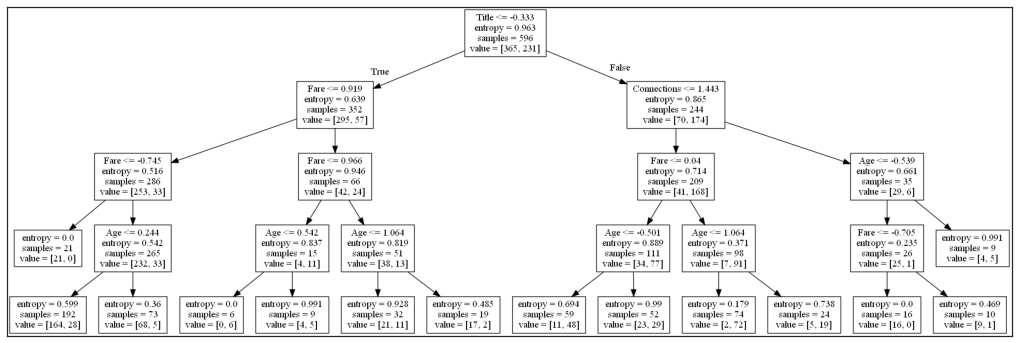

In [236]:
# visualize
def viewTree(tree, features, path):
    f = io.StringIO()
    export_graphviz(tree, out_file=f, feature_names=features)
    pydotplus.graph_from_dot_data(f.getvalue()).write_png(path)
    img = imageio.imread(path)
    fig, ax = plt.subplots(figsize=(18, 7))
    plt.imshow(img)
    ax.set_xticklabels(labels='')
    ax.set_yticklabels(labels='')
viewTree(dt_clf, headers, 'dtree_01.png')

## 3.6. Random Forest

In [237]:
# tuning hyperparameters
param_grid = [{'n_estimators':[100, 250, 500], 'criterion': ['gini', 'entropy'], 'max_depth': [3, 4, 6],
               'min_samples_leaf':[1, 3, 5], 'max_leaf_nodes':[16, 32, 64]}]
rf = RandomForestClassifier()
rf_grid = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, return_train_score=False)
grid_results = rf_grid.fit(X_train, y_train)
grid_table = pd.DataFrame(grid_results.cv_results_)
grid_results.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'max_leaf_nodes': 32,
 'min_samples_leaf': 1,
 'n_estimators': 100}

In [238]:
# call and fit
model_name.append('Random Forest')
rf_clf = RandomForestClassifier(criterion='entropy', max_depth=4, max_leaf_nodes=64, n_estimators=500, n_jobs=-1)
rf_clf.fit(X_train, y_train)

# predict
y_pred = rf_clf.predict(X_test)

RandomForestClassifier(criterion='entropy', max_depth=4, max_leaf_nodes=64,
                       n_estimators=500, n_jobs=-1)

In [239]:
# evaluate
rf_report = classification_report(y_test, y_pred)
print(rf_report)
acc_scores.append(round(accuracy_score(y_test, y_pred), 4))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       184
           1       0.77      0.75      0.76       111

    accuracy                           0.82       295
   macro avg       0.81      0.81      0.81       295
weighted avg       0.82      0.82      0.82       295



In [240]:
# feature importance
for name, score in zip(headers, rf_clf.feature_importances_):
    print(name, ':', score)

Title : 0.28096822286191875
Sex : 0.25577755409619257
Age : 0.09183443509387361
Class : 0.11294957059861278
Embarked : 0.03097342206428071
Connections : 0.07778940295467363
Fare : 0.14970739233044775


## 3.7. Soft Voting Classifier

In [241]:
# call and fit
model_name.append('Soft Voting Classifier')
voting_clf = VotingClassifier(estimators=[('lr', log_reg), ('svm', sv_clf), ('knn', knn_clf), ('rf', rf_clf)], voting="soft")
voting_clf.fit(X_train, y_train)

# predict
y_pred = voting_clf.predict(X_test)

VotingClassifier(estimators=[('lr', LogisticRegression(solver='newton-cg')),
                             ('svm', SVC(probability=True)),
                             ('knn',
                              KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=4)),
                             ('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=4,
                                                     max_leaf_nodes=64,
                                                     n_estimators=500,
                                                     n_jobs=-1))],
                 voting='soft')

In [242]:
# evaluate
voting_report = classification_report(y_test, y_pred)
print(voting_report)
acc_scores.append(round(accuracy_score(y_test, y_pred), 4))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       184
           1       0.79      0.73      0.76       111

    accuracy                           0.83       295
   macro avg       0.82      0.81      0.81       295
weighted avg       0.83      0.83      0.83       295



In [243]:
# # dicts
# cmap2 = ListedColormap(["steelblue", "lightblue"])
# marker = ["s", "s"]
# color = ["steelblue", "goldenrod"]

# # contour
# x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
# y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
#                      np.arange(y_min, y_max, 0.1))

# # dataset
# dec_df = pd.DataFrame(data=np.column_stack([X_train, y_train]), columns=["X", "Y", "fate"])

# # plot
# fig, ax = plt.subplots(figsize=(7, 6))
# Z = voting_clf.predict(np.c_[xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)
# ax.contourf(xx, yy, Z, alpha=0.4, cmap=cmap2)
# for i in range(1):
#     data = dec_df[dec_df['fate']==i]
#     ax.scatter('X', 'Y', c=color[i], data=data, marker=marker[i], alpha=1,
#                                   s=30, edgecolor=None)
#     ax.set_title('Voting Classifier Decision Boundary', fontsize=18, pad=15)
#     ax.set_xlabel('Age (standardized)')
#     ax.set_ylabel('Fare (standardized)')
# plt.show()

## 3.8. Plot Best Model

In [244]:
acc_perc = [scores*100 for scores in acc_scores]
model_select = pd.DataFrame(zip(model_name, acc_perc), columns=["Algorithm", "Accuracy"]).sort_values(by="Accuracy", 
                                                                                                      ascending=False)
model_select.reset_index(drop=True, inplace=True)
model_select

,Algorithm,Accuracy
0,K-nearest Neighbors,82.71
1,Soft Voting Classifier,82.71
2,Support Vector Classifier,82.37
3,Random Forest,82.03
4,Logistic Regression,78.64
5,Decision Tree,77.63


Text(0.5, 1.0, 'Model Selection')

Text(0.5, 0, 'Accuracy (%)')

Text(0, 0.5, '')

Text(82.71, 0, ' 82.71')

Text(82.71, 1, ' 82.71')

Text(82.37, 2, ' 82.37')

Text(82.03, 3, ' 82.03')

Text(78.64, 4, ' 78.64')

Text(77.63, 5, ' 77.63')

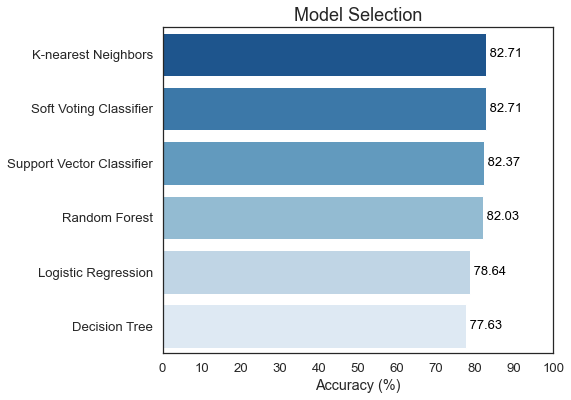

In [245]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.barplot(x='Accuracy', y='Algorithm', data=model_select, palette='Blues_r')
ax.set_title('Model Selection', fontsize=18)
ax.set_xlabel('Accuracy (%)')
ax.set_ylabel('')
ax.set_xticks(np.arange(0, 110, 10))
for index, row in model_select.iterrows():
    ax.text(row.Accuracy, row.name, ' {}'.format(row.Accuracy), color="black", va="center", ha="left", fontsize=13)

In [246]:
# top model predictions
y_top_mod = voting_clf.predict(X_test)

In [247]:
# plot function
def plt_cm(y_known, y_pred, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_known, y_pred)
    cm_norm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(7, 6))
    ax.imshow(cm_norm, interpolation="nearest", cmap=cmap)
    ax.set_xlabel('Predicted Fate')
    ax.set_ylabel('Known Fate')
    ax.set_xticks(np.arange(cm_norm.shape[1]))
    ax.set_yticks(np.arange(cm_norm.shape[0]))
    ax.set_title(title, fontsize=18, pad=15)
    txt_format = '.2f'
    threshold = cm_norm.max() / 2.
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            ax.text(j, i, format(cm_norm[i, j], txt_format),
                    ha="center", va="center", fontsize=13,
                    color="white" if cm_norm[i, j] > threshold else "black")
    return ax

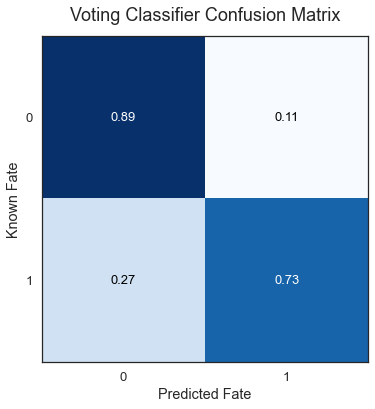

In [248]:
# plot top model
plt_cm(y_test, y_top_mod, title='Voting Classifier Confusion Matrix')

In [249]:
# final predictions
final_pred = voting_clf.predict(test_df)

In [264]:
# submission
submission = pd.DataFrame({"PassengerId":test_ID, 
                           "Survived":final_pred})
submission['Survived'].value_counts()/len(submission)

0    0.631579
1    0.368421
Name: Survived, dtype: float64